# Tutorial HANNAH Framework 
## AutoML School
### Hannover 2024 


### Setup tooling

In [22]:
!pip install  "hannah[vision,performancemodel]@git+https://github.com/ekut-es/hannah.git@pub/automlschool24"


Looking in indexes: https://pypi.org/simple, https://pypi.ngc.nvidia.com
  Cloning https://github.com/ekut-es/hannah.git (to revision pub/automlschool24) to /tmp/pip-install-yt_hjuoc/hannah_7e196dc56791468eba57d1651af9317e
  Running command git clone --filter=blob:none --quiet https://github.com/ekut-es/hannah.git /tmp/pip-install-yt_hjuoc/hannah_7e196dc56791468eba57d1651af9317e
  Running command git checkout -b pub/automlschool24 --track origin/pub/automlschool24
  Switched to a new branch 'pub/automlschool24'
  branch 'pub/automlschool24' set up to track 'origin/pub/automlschool24'.
  Resolved https://github.com/ekut-es/hannah.git to commit 2e3eb901eabe2dd3e57dfee1ee2e85923764cfcc
  Running command git submodule update --init --recursive -q
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done


### Setup library

In [23]:
import hannah
import pathlib
import torch
import os
from contextlib import contextmanager
import sys
import nn_meter
from IPython.display import Code, display



# Modify the python module search path to include the current directory
sys.path.append(str(pathlib.Path.cwd()))


@contextmanager
def change_wd(path: pathlib.Path, create: bool = True, clean: bool = False):
    current = pathlib.Path.cwd()
    
    if clean and path.exists():
        import shutil
        shutil.rmtree(path)
        path.mkdir(parents=True)
    
    if create and not path.exists():
        path.mkdir(parents=True)    
    
    try:
        os.chdir(path)
        yield
    finally:
        os.chdir(current)
    
# Setup logging
import logging
logging.basicConfig(level=logging.INFO)


### Create Search Space
First we create a simple search space. This search space description is written to a file such that the `hydra` config framework
can refer to it and instantiate the search space. 

The search space consists of a variable number of `conv_relu` blocks with a `linear` layer at the end. 



In [24]:
%%writefile space.py
from hannah.nas.functional_operators.op import ChoiceOp, Tensor, scope
from hannah.nas.functional_operators.operators import AdaptiveAvgPooling, Conv2d, Linear, Relu
from hannah.nas.functional_operators.op import search_space
from hannah.nas.parameters.parameters import CategoricalParameter, IntScalarParameter


@scope
def conv_relu(input, kernel_size, out_channels, stride):
    in_channels = input.shape()[1]
    weight = Tensor(name='weight',
                    shape=(out_channels, in_channels, kernel_size, kernel_size),
                    axis=('O', 'I', 'kH', 'kW'),
                    grad=True)

    conv = Conv2d(stride=stride)(input, weight)
    relu = Relu()(conv)
    return relu


def adaptive_avg_pooling(input):
    return AdaptiveAvgPooling()(input)


def dynamic_depth(*exits, switch):
    return ChoiceOp(*exits, switch=switch)()


def linear(input, out_features):
    input_shape = input.shape()
    in_features = input_shape[1] * input_shape[2] * input_shape[3]
    weight = Tensor(name='weight',
                    shape=(in_features, out_features),
                    axis=('in_features', 'out_features'),
                    grad=True)

    out = Linear()(input, weight)
    return out


@scope
def classifier_head(input, num_classes):
    out = adaptive_avg_pooling(input)
    out = linear(out, num_classes)
    return out


@search_space
def cnn_search_space(name, input, max_blocks=3, max_channels=64, num_classes=10):
    out_channels = IntScalarParameter(16, max_channels, step_size=8, name="out_channels")
    kernel_size = CategoricalParameter([3, 5, 7, 9], name="kernel_size")
    stride = CategoricalParameter([1, 2], name="stride")
    num_blocks = IntScalarParameter(1, max_blocks, name="num_blocks")
    exits = []
    out = input
    for i in range(num_blocks.max + 1):
        out = conv_relu(out,
                        stride=stride.new(),
                        out_channels=out_channels.new(),
                        kernel_size=kernel_size.new())
        exits.append(out)

    out = dynamic_depth(*exits, switch=num_blocks)
    out = classifier_head(out, num_classes=num_classes)
    return out

Overwriting space.py


Now we create a config file for `hydra`:

In [25]:
from omegaconf import OmegaConf
import os

cfg_dict ={"_target_": "space.cnn_search_space",
           "name": "cnn_search_space",
           "num_classes": 10,
           "max_channels": 32,
           "max_blocks": 2}

cfg = OmegaConf.create(cfg_dict)

if not os.path.exists("model"):
    os.mkdir("model")
OmegaConf.save(config=cfg, f="model/cnn_search_space.yaml")


### Configure NAS

In [26]:
%%writefile config.yaml

defaults:
    - base_config
    - override dataset: mnist   # Dataset configuration name
    - override features: identity        # Feature extractor configuration name (use identity for vision datasets)
    # - override model: timm_mobilenetv3_small_075      # Neural network name (for now timm_resnet50 or timm_efficientnet_lite1)
    - override scheduler: 1cycle         # learning rate scheduler config name
    - override optimizer: adamw          # Optimizer config name
    - override normalizer: null          # Feature normalizer (used for quantized neural networks)
    - override module: image_classifier  # Lightning module config for the training loop (image classifier for image classification tasks)
    - _self_


dataset:
  data_folder: ${oc.env:HANNAH_DATA_FOLDER,${hydra:runtime.cwd}/../../datasets/}

module:
  batch_size: 128
  num_workers: 0

nas:
  budget: 5
  total_candidates: 5
  num_selected_candidates: 10

trainer:
  max_epochs: 2
  devices: null
  accelerator: cpu 
  enable_progress_bar: False
  limit_train_batches: 0.1

scheduler:
  max_lr: 0.001

fx_mac_summary: True

Overwriting config.yaml


### Run NAS

Now we can run the NAS in the "terminal". Note, that we have to append the current working directory to the PYTHONPATH such 
that the search space located in our current directory can be found. If the model file where to be located in the `hannah/models/`
directory that would not be necessary.

In [27]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run1", create=True, clean=False):
        main(cfg)

INFO:hannah.utils.utils:Environment info:
INFO:hannah.utils.utils:  Number of GPUs: 2
INFO:hannah.utils.utils:  CUDA version: 12.1
INFO:hannah.utils.utils:  CUDNN version: 8907
INFO:hannah.utils.utils:  Kernel: 4.18.0-553.16.1.el8_10.x86_64
INFO:hannah.utils.utils:  Python: 3.11.9 (main, Jun 24 2024, 06:19:13) [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]
INFO:hannah.utils.utils:  PyTorch: 2.2.2+cu121
INFO:hannah.utils.utils:  Pytorch Lightning: 2.4.0
INFO:hannah.utils.utils:  Numpy: 1.26.4
INFO:hannah.utils.utils:  Hannah version info:
INFO:hannah.utils.utils:    Cannot find a Git repository.  You probably downloaded an archive
INFO:hannah.utils.utils:  Command line: /local/gerum/.cache/pypoetry/virtualenvs/hannah-8Yp6PnCx-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/gerum/.local/share/jupyter/runtime/kernel-v2-2282314LcCBIBgxMbcV.json
INFO:hannah.utils.utils:  



 **                                            **
/**                                           /**
/**       ******   *******  *******   ******  /**
/******  //////** //**///**//**///** //////** /******
/**///**  *******  /**  /** /**  /**  ******* /**///**
/**  /** **////**  /**  /** /**  /** **////** /**  /**
/**  /**//******** ***  /** ***  /**//********/**  /**
//   //  //////// ///   // ///   //  //////// //   //

dataset:
  data_folder: /local/gerum/hannah/tutorials/automlschool24/data
  cls: hannah.datasets.vision.MNISTDataset
  dataset: mnist
  val_percent: 0.1
features:
  _target_: torch.nn.Identity
model:
  _target_: space.cnn_search_space
  name: cnn_search_space
  num_classes: 10
  max_channels: 32
  max_blocks: 2
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  max_lr: 0.001
  pct_start: 0.3
  anneal_strategy: cos
  cycle_momentum: true
  base_momentum: 0.85
  max_momentum: 0.95
  div_factor: 25.0
  final_div_factor: 10000.0
  last_epoch: -1
optimizer:
  _tar

INFO:hannah.nas.search.sampler.base_sampler:Loaded 5 points from history
INFO:hannah.callbacks.optimization:Monitoring the following values for optimization
INFO:hannah.callbacks.optimization:  - val_error direction: minimize(1)


### Evaluate

The results of the neural architecture search are then saved in `run1/history.yml`

In [28]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run1" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,est_act,ff,total_act,total_macs,total_weights,val_error
0,25088.0,0.084654,38490.0,8442432.0,42192.0,0.239130
1,12544.0,0.050296,14938.0,1386272.0,26048.0,0.178668
2,50176.0,0.204958,88650.0,48997104.0,62736.0,0.257812
3,50176.0,0.071435,63578.0,11866944.0,53088.0,0.133492
4,9408.0,0.102026,25930.0,11054640.0,56640.0,0.094429


# Getting Hardware into the Picture

## Hardware aware NAS

Many approaches to integrate hardware properties into the optimization loop use hardware measurements of inference latency or energy consumption as target functions for the optimization loop. We can do the same, by using

1. By directly measuring the neural network`s  exection time using a compilation backend
2. By using a prefitted estimator that predicts the performance measurements
3. By using a hardware model that estimates harware metrics using analytical or functional modeling

## Hardware Aware-NAS

In this case we use a pretrained performance estimator [nn-meter](https://github.com/microsoft/nn-Meter). 

The performance estimator has been pretrained for the following devices and inference frameworks:

|       Device       |   Framework   |   Processor   |      Hardware name      |
| :-----------------: | :------------: | :------------: | :----------------------: |
|       Pixel4       |  TFLite v2.1  | CortexA76 CPU |    cortexA76cpu_tflite21  |
|         Mi9         |  TFLite v2.1  | Adreno 640 GPU |    adreno640gpu_tflite21  |
|      Pixel3XL      |  TFLite v2.1  | Adreno 630 GPU |   adreno630gpu_tflite21  |
| Intel Movidius NCS2 | OpenVINO2019R2 |   Myriad VPU   |   myriadvpu_openvino2019r2 |

`nn-meter` has been integrated into hannah and can be used as a performance estimator by adding it to the configuration. 

Using the overwrites: `nas/predictor=nn-meter nas.predictor.nn_meter.hardware_name=<hardware_name>

The following adds the `nn-meter` predictor to the list of predictors, and configures the multiobjective optimization to also consider the reported duration per inference, searching for models with an uper execution time bound of 0.1 ms on the given target hardware. 

In [29]:
from hannah.tools.train import main
from hydra import compose, initialize_config_module

wd = pathlib.Path.cwd()

with initialize_config_module("hannah.conf", version_base="1.2"):
    cfg = compose(config_name="config", overrides=["nas/predictor=[nn-meter,macs,gcn]", "+hannah.nas.bounds.duration=0.2", "model=cnn_search_space", "nas=random_nas", "trainer.max_epochs=1", "dataset=mnist", f"dataset.data_folder={wd / 'data'}", "module.num_workers=8", "nas.presample=false"])
    
    with change_wd(wd / "run_nn_meter", create=True, clean=False):
        main(cfg)

INFO:hannah.utils.utils:Environment info:
INFO:hannah.utils.utils:  Number of GPUs: 2
INFO:hannah.utils.utils:  CUDA version: 12.1
INFO:hannah.utils.utils:  CUDNN version: 8907
INFO:hannah.utils.utils:  Kernel: 4.18.0-553.16.1.el8_10.x86_64
INFO:hannah.utils.utils:  Python: 3.11.9 (main, Jun 24 2024, 06:19:13) [GCC 8.5.0 20210514 (Red Hat 8.5.0-22)]
INFO:hannah.utils.utils:  PyTorch: 2.2.2+cu121
INFO:hannah.utils.utils:  Pytorch Lightning: 2.4.0
INFO:hannah.utils.utils:  Numpy: 1.26.4
INFO:hannah.utils.utils:  Hannah version info:
INFO:hannah.utils.utils:    Cannot find a Git repository.  You probably downloaded an archive
INFO:hannah.utils.utils:  Command line: /local/gerum/.cache/pypoetry/virtualenvs/hannah-8Yp6PnCx-py3.11/lib/python3.11/site-packages/ipykernel_launcher.py --f=/home/gerum/.local/share/jupyter/runtime/kernel-v2-2282314LcCBIBgxMbcV.json
INFO:hannah.utils.utils:  



 **                                            **
/**                                           /**
/**       ******   *******  *******   ******  /**
/******  //////** //**///**//**///** //////** /******
/**///**  *******  /**  /** /**  /**  ******* /**///**
/**  /** **////**  /**  /** /**  /** **////** /**  /**
/**  /**//******** ***  /** ***  /**//********/**  /**
//   //  //////// ///   // ///   //  //////// //   //

dataset:
  data_folder: /local/gerum/hannah/tutorials/automlschool24/data
  cls: hannah.datasets.vision.MNISTDataset
  dataset: mnist
  val_percent: 0.1
features:
  _target_: torch.nn.Identity
model:
  _target_: space.cnn_search_space
  name: cnn_search_space
  num_classes: 10
  max_channels: 32
  max_blocks: 2
scheduler:
  _target_: torch.optim.lr_scheduler.OneCycleLR
  max_lr: 0.001
  pct_start: 0.3
  anneal_strategy: cos
  cycle_momentum: true
  base_momentum: 0.85
  max_momentum: 0.95
  div_factor: 25.0
  final_div_factor: 10000.0
  last_epoch: -1
optimizer:
  _tar

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(

https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(



(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/dwconv-bn-relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/maxpool.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/hswish.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/se.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/avgpool.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/bn.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/conv-bn-relu.pkl
(nn-Meter) load predictor /local/gerum/.nn_meter/data/predictor/adreno630gpu_tflite21/bnrelu.pkl


INFO:hannah.callbacks.optimization:Monitoring the following values for optimization
INFO:hannah.callbacks.optimization:  - val_error direction: minimize(1)
INFO:hannah.nas.search.search:Sampling candidate 0
INFO:root:transfering model to onnx
INFO:root:Creating onnxrt-model


(nn-Meter) Start latency prediction ...
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0


INFO:root:{'op': 'dwconv-relu', 'name': 'dwconv-relu#0', 'input_tensors': [[0, 28, 28, 1]], 'ks': [9, 9], 'strides': [2, 2], 'inputh': 28, 'inputw': 28, 'cin': 1, 'cout': 24, 'inbounds': [], 'outbounds': ['conv-relu#1']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#1', 'input_tensors': [[0, 14, 14, 24]], 'ks': [3, 3], 'strides': [1, 1], 'inputh': 14, 'inputw': 14, 'cin': 24, 'cout': 32, 'inbounds': ['dwconv-relu#0'], 'outbounds': ['conv-relu#2']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#2', 'input_tensors': [[0, 14, 14, 32]], 'ks': [9, 9], 'strides': [1, 1], 'inputh': 14, 'inputw': 14, 'cin': 32, 'cout': 16, 'inbounds': ['conv-relu#1'], 'outbounds': ['gap#3']}
INFO:root:{'op': 'gap', 'name': 'gap#3', 'input_tensors': [[0, 14, 14, 16]], 'inputh': 14, 'inputw': 14, 'cin': 16, 'cout': 16, 'inbounds': ['conv-relu#2'], 'outbounds': ['fc#4']}
INFO:root:{'op': 'fc', 'name': 'fc#4', 'input_tensors': [[0, 16]], 'cin': 16, 'cout': 10, 'inbounds': ['gap#3'], 'outbounds': []}


(nn-Meter) Predict latency: 0.4949829174545452 ms


INFO:hannah.nas.search.search:Predicted metrics from nn_meter predictor:
INFO:hannah.nas.search.search:  duration: 0.49498292
INFO:hannah.nas.search.search:Predicted metrics from macs predictor:
INFO:hannah.nas.search.search:  total_macs: 9864448.00000000
INFO:hannah.nas.search.search:  total_weights: 50488.00000000
INFO:hannah.nas.search.search:  total_act: 29050.00000000
INFO:hannah.nas.search.search:  est_act: 12544.00000000
INFO:hannah.nas.performance_prediction.simple:Predicted performance metrics
INFO:hannah.nas.performance_prediction.simple:val_error: 0.0
INFO:hannah.nas.search.search:Predicted metrics from gcn predictor:
INFO:hannah.nas.search.search:  val_error: 0.00000000
INFO:hannah.nas.search.search:total_macs: 9864448.00000000 (0.08)
INFO:hannah.nas.search.search:total_weights: 50488.00000000 (0.10)
INFO:hannah.nas.search.search:val_error: 0.00000000 (0.00)
INFO:hannah.nas.search.search:Sampling candidate 1
INFO:root:transfering model to onnx
INFO:root:Creating onnxrt-mode

(nn-Meter) Start latency prediction ...
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0


INFO:root:{'op': 'dwconv-relu', 'name': 'dwconv-relu#0', 'input_tensors': [[0, 28, 28, 1]], 'ks': [9, 9], 'strides': [2, 2], 'inputh': 28, 'inputw': 28, 'cin': 1, 'cout': 32, 'inbounds': [], 'outbounds': ['conv-relu#1']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#1', 'input_tensors': [[0, 14, 14, 32]], 'ks': [3, 3], 'strides': [1, 1], 'inputh': 14, 'inputw': 14, 'cin': 32, 'cout': 32, 'inbounds': ['dwconv-relu#0'], 'outbounds': ['conv-relu#2']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#2', 'input_tensors': [[0, 14, 14, 32]], 'ks': [7, 7], 'strides': [1, 1], 'inputh': 14, 'inputw': 14, 'cin': 32, 'cout': 32, 'inbounds': ['conv-relu#1'], 'outbounds': ['gap#3']}
INFO:root:{'op': 'gap', 'name': 'gap#3', 'input_tensors': [[0, 14, 14, 32]], 'inputh': 14, 'inputw': 14, 'cin': 32, 'cout': 32, 'inbounds': ['conv-relu#2'], 'outbounds': ['fc#4']}
INFO:root:{'op': 'fc', 'name': 'fc#4', 'input_tensors': [[0, 32]], 'cin': 32, 'cout': 10, 'inbounds': ['gap#3'], 'outbounds': []}


(nn-Meter) Predict latency: 0.4535988994393932 ms


INFO:hannah.nas.search.search:Predicted metrics from nn_meter predictor:
INFO:hannah.nas.search.search:  duration: 0.45359890
INFO:hannah.nas.search.search:Predicted metrics from macs predictor:
INFO:hannah.nas.search.search:  total_macs: 12149184.00000000
INFO:hannah.nas.search.search:  total_weights: 62304.00000000
INFO:hannah.nas.search.search:  total_act: 38490.00000000
INFO:hannah.nas.search.search:  est_act: 12544.00000000
INFO:hannah.nas.performance_prediction.simple:Predicted performance metrics
INFO:hannah.nas.performance_prediction.simple:val_error: 0.0
INFO:hannah.nas.search.search:Predicted metrics from gcn predictor:
INFO:hannah.nas.search.search:  val_error: 0.00000000
INFO:hannah.nas.search.search:total_macs: 12149184.00000000 (0.09)
INFO:hannah.nas.search.search:total_weights: 62304.00000000 (0.12)
INFO:hannah.nas.search.search:val_error: 0.00000000 (0.00)
INFO:hannah.nas.search.search:Sampling candidate 2
INFO:root:transfering model to onnx
INFO:root:Creating onnxrt-mo

(nn-Meter) Start latency prediction ...
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0


INFO:root:{'op': 'dwconv-relu', 'name': 'dwconv-relu#0', 'input_tensors': [[0, 28, 28, 1]], 'ks': [5, 5], 'strides': [1, 1], 'inputh': 28, 'inputw': 28, 'cin': 1, 'cout': 32, 'inbounds': [], 'outbounds': ['conv-relu#1']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#1', 'input_tensors': [[0, 28, 28, 32]], 'ks': [9, 9], 'strides': [2, 2], 'inputh': 28, 'inputw': 28, 'cin': 32, 'cout': 32, 'inbounds': ['dwconv-relu#0'], 'outbounds': ['gap#2']}
INFO:root:{'op': 'gap', 'name': 'gap#2', 'input_tensors': [[0, 14, 14, 32]], 'inputh': 14, 'inputw': 14, 'cin': 32, 'cout': 32, 'inbounds': ['conv-relu#1'], 'outbounds': ['fc#3']}
INFO:root:{'op': 'fc', 'name': 'fc#3', 'input_tensors': [[0, 32]], 'cin': 32, 'cout': 10, 'inbounds': ['gap#2'], 'outbounds': []}


(nn-Meter) Predict latency: 0.6273215420075748 ms


INFO:hannah.nas.search.search:Predicted metrics from nn_meter predictor:
INFO:hannah.nas.search.search:  duration: 0.62732154
INFO:hannah.nas.search.search:Predicted metrics from macs predictor:
INFO:hannah.nas.search.search:  total_macs: 16884544.00000000
INFO:hannah.nas.search.search:  total_weights: 84064.00000000
INFO:hannah.nas.search.search:  total_act: 63578.00000000
INFO:hannah.nas.search.search:  est_act: 50176.00000000
INFO:hannah.nas.performance_prediction.simple:Predicted performance metrics
INFO:hannah.nas.performance_prediction.simple:val_error: 0.0
INFO:hannah.nas.search.search:Predicted metrics from gcn predictor:
INFO:hannah.nas.search.search:  val_error: 0.00000000
INFO:hannah.nas.search.search:total_macs: 16884544.00000000 (0.13)
INFO:hannah.nas.search.search:total_weights: 84064.00000000 (0.17)
INFO:hannah.nas.search.search:val_error: 0.00000000 (0.00)
INFO:hannah.nas.search.search:Sampling candidate 3
INFO:root:transfering model to onnx
INFO:root:Creating onnxrt-mo

(nn-Meter) Start latency prediction ...
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0
(nn-Meter) onnx==1.16.2 is not well tested now, well tested version: onnx==1.10.0, 1.9.0


INFO:root:{'op': 'dwconv-relu', 'name': 'dwconv-relu#0', 'input_tensors': [[0, 28, 28, 1]], 'ks': [9, 9], 'strides': [1, 1], 'inputh': 28, 'inputw': 28, 'cin': 1, 'cout': 16, 'inbounds': [], 'outbounds': ['conv-relu#1']}
INFO:root:{'op': 'conv-relu', 'name': 'conv-relu#1', 'input_tensors': [[0, 28, 28, 16]], 'ks': [9, 9], 'strides': [1, 1], 'inputh': 28, 'inputw': 28, 'cin': 16, 'cout': 16, 'inbounds': ['dwconv-relu#0'], 'outbounds': ['gap#2']}
INFO:root:{'op': 'gap', 'name': 'gap#2', 'input_tensors': [[0, 28, 28, 16]], 'inputh': 28, 'inputw': 28, 'cin': 16, 'cout': 16, 'inbounds': ['conv-relu#1'], 'outbounds': ['fc#3']}
INFO:root:{'op': 'fc', 'name': 'fc#3', 'input_tensors': [[0, 16]], 'cin': 16, 'cout': 10, 'inbounds': ['gap#2'], 'outbounds': []}


(nn-Meter) Predict latency: 0.5409724064772724 ms


INFO:hannah.nas.search.search:Predicted metrics from nn_meter predictor:
INFO:hannah.nas.search.search:  duration: 0.54097241
INFO:hannah.nas.search.search:Predicted metrics from macs predictor:
INFO:hannah.nas.search.search:  total_macs: 17273248.00000000
INFO:hannah.nas.search.search:  total_weights: 22192.00000000
INFO:hannah.nas.search.search:  total_act: 51002.00000000
INFO:hannah.nas.search.search:  est_act: 25088.00000000


The search yielded the following results:

In [ ]:
import pandas as pd 
import yaml

history = yaml.unsafe_load((wd / "run_nn_meter" / "history.yml").read_text())

df = pd.DataFrame((item.result for item in history))
df

,duration,est_act,ff,total_act,total_macs,total_weights,val_error
0,0.184794,50176.0,0.032455,88650.0,5645040.0,7440.0,0.633832
1,0.288916,12544.0,0.059475,25914.0,6074592.0,31152.0,0.131624
2,0.318278,25088.0,0.065695,38490.0,8241728.0,41936.0,0.283458
3,0.650467,50176.0,0.068600,72970.0,17436400.0,88336.0,0.107507
4,0.094113,9408.0,0.014139,16522.0,1910064.0,9984.0,0.418988


As the number of multiply accumulate operations is often used as a first order approximation we can also have a look at a comparison of the number of MAC operations in the networks versus their actual runtimes. 

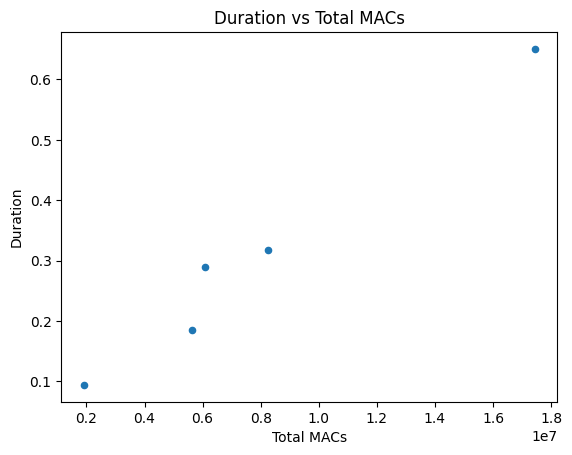

In [ ]:
import matplotlib.pyplot as plt

df.plot(x='total_macs', y='duration', kind='scatter')
plt.xlabel('Total MACs')
plt.ylabel('Duration')
plt.title('Duration vs Total MACs')
plt.show()